# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 24.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [3]:
import keras
from keras.datasets import fashion_mnist

(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', verbose=True):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.verbose = verbose
        if classifier == 'logreg':
            self.classifier = LogisticRegression()
        else:
            self.classifier = LinearSVC()
    
    def compute_sigma(self, X):
        meds = []
        for i in tqdm(range(1000000), display=self.verbose):
            rand_i = np.random.randint(0, X.shape[0])
            rand_j = np.random.randint(0, X.shape[0])
            if rand_i != rand_j:
                meds.append(np.sum((X[rand_i] - X[rand_j]) * (X[rand_i] - X[rand_j])))
        return np.sqrt(np.median(meds))
        
    def fit(self, X, y, sigma=None):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
        if sigma is None:
            self.sigma = self.compute_sigma(X)
        else:
            self.sigma = sigma
        self.w = np.random.normal(loc=0, scale=1/self.sigma, size=(X.shape[1], self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=(self.n_features))
        X_new = np.cos(np.dot(X, self.w) + self.b)
        self.classifier.fit(X_new, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        return self.classifier.predict_proba(X)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X = np.cos(np.dot(X, self.w) + self.b)
        return self.classifier.predict(X)

In [ ]:
%%time
from sklearn.svm import LinearSVC

rffp = RFFPipeline()
rffp.fit(x_train, y_train)


y_pred = rffp.predict(x_test)
print('----')
print('Logistic Regression with rffp features', accuracy_score(y_test, y_pred))

  0%|          | 0/1000000 [00:00<?, ?it/s]

----
Logistic Regression with rffp features 0.8567
CPU times: user 1min 26s, sys: 4.32 s, total: 1min 31s
Wall time: 57.3 s


In [ ]:
%%time
rffp = RFFPipeline(classifier='svm')
rffp.fit(x_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = rffp.predict(x_test)
print('----')
print('SVM with rffp features', accuracy_score(y_test, y_pred))

  0%|          | 0/1000000 [00:00<?, ?it/s]

----
SVM with rffp features 0.8752
CPU times: user 6min 1s, sys: 4.07 s, total: 6min 6s
Wall time: 6min 9s



__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [ ]:
%%time

clf = LinearSVC()
clf.fit(x_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = clf.predict(x_test)
print('----')
print('Linear SVM on the original features', accuracy_score(y_test, y_pred))

----
Linear SVM on the original features 0.7856
CPU times: user 4min 47s, sys: 1.08 s, total: 4min 48s
Wall time: 4min 51s


In [ ]:
%%time
from sklearn.svm import SVC

clf = SVC(kernel='rbf')
clf.fit(x_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = clf.predict(x_test)
print('----')
print('SVM with rbf kernel', accuracy_score(y_test, y_pred))

----
SVM with rbf kernel 0.8828
CPU times: user 6min 23s, sys: 3.14 s, total: 6min 27s
Wall time: 6min 29s


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

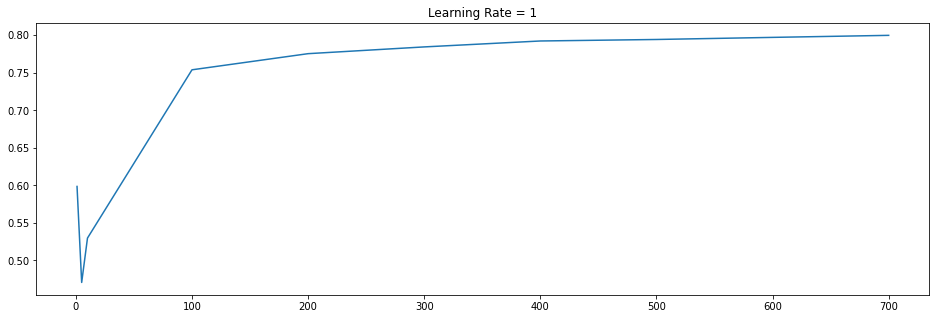

  0%|          | 0/10 [00:00<?, ?it/s]

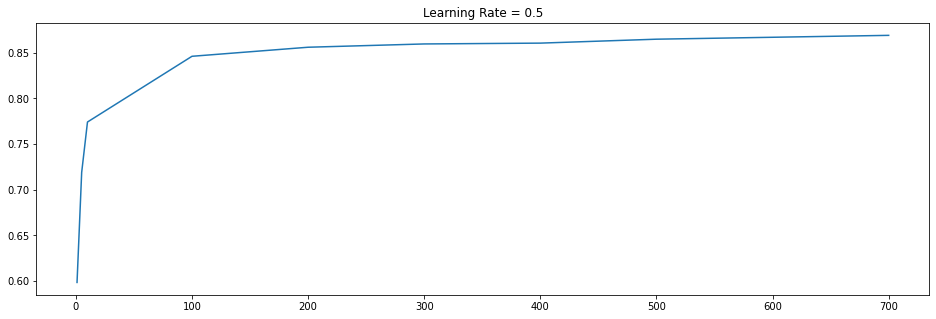

  0%|          | 0/10 [00:00<?, ?it/s]

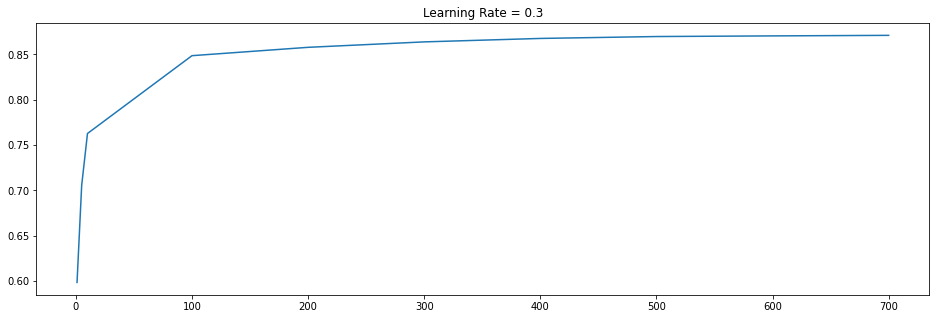

  0%|          | 0/10 [00:00<?, ?it/s]

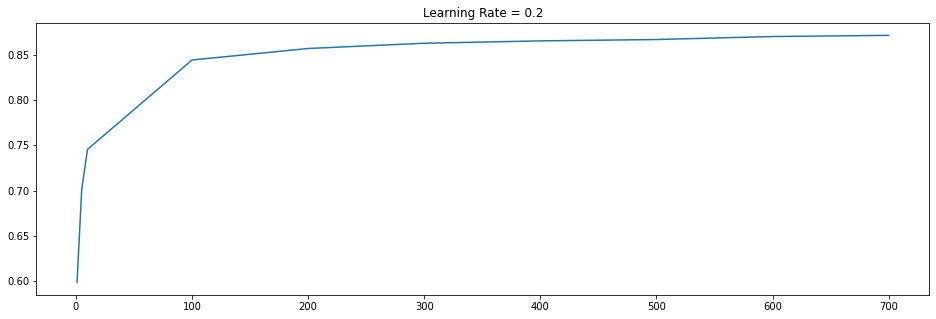

  0%|          | 0/10 [00:00<?, ?it/s]

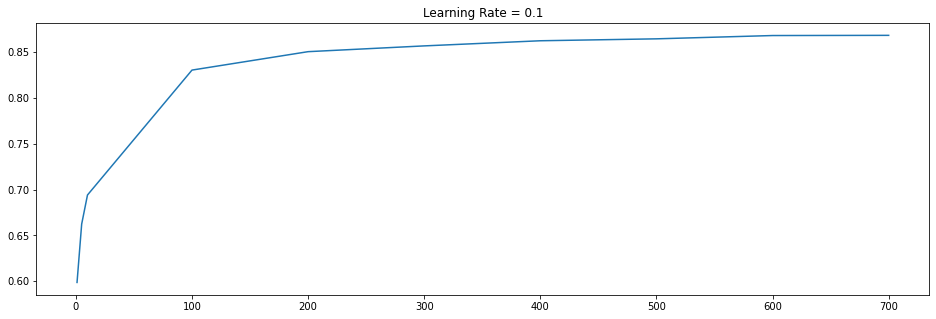

In [6]:
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

learning_rate = [1, 0.5, 0.3, 0.2, 0.1]
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]

for lr in tqdm(learning_rate):
    accs = []
    for num_trees in tqdm(n_trees):
        model = CatBoostClassifier(learning_rate=lr,
                                   num_trees=num_trees, task_type="GPU", devices='0:1')
        model.fit(x_train_pca, y_train, verbose=False)
        y_pred = model.predict(x_test_pca)
        accs.append(accuracy_score(y_test, y_pred))
    plt.figure(figsize=(16,5))
    plt.plot(n_trees, accs)
    plt.title('Learning Rate = {}'.format(lr))
    plt.show()

In [6]:
%%time
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

model = CatBoostClassifier(learning_rate=0.1,
                           num_trees=600)
model.fit(x_train_pca, y_train, verbose=True)
y_pred = model.predict(x_test_pca)
print('----')
print('Catboost, PCA', accuracy_score(y_test, y_pred))

0:	learn: 1.9614834	total: 246ms	remaining: 2m 27s
1:	learn: 1.7522798	total: 426ms	remaining: 2m 7s
2:	learn: 1.6050528	total: 658ms	remaining: 2m 10s
3:	learn: 1.4875228	total: 840ms	remaining: 2m 5s
4:	learn: 1.3967672	total: 1.07s	remaining: 2m 7s
5:	learn: 1.3169547	total: 1.28s	remaining: 2m 7s
6:	learn: 1.2509264	total: 1.48s	remaining: 2m 5s
7:	learn: 1.1923199	total: 1.71s	remaining: 2m 6s
8:	learn: 1.1391592	total: 1.89s	remaining: 2m 4s
9:	learn: 1.0899524	total: 2.13s	remaining: 2m 5s
10:	learn: 1.0478476	total: 2.36s	remaining: 2m 6s
11:	learn: 1.0118458	total: 2.61s	remaining: 2m 8s
12:	learn: 0.9803881	total: 3.09s	remaining: 2m 19s
13:	learn: 0.9553788	total: 3.56s	remaining: 2m 29s
14:	learn: 0.9260254	total: 4.08s	remaining: 2m 39s
15:	learn: 0.9016111	total: 4.53s	remaining: 2m 45s
16:	learn: 0.8768701	total: 4.73s	remaining: 2m 42s
17:	learn: 0.8539543	total: 4.93s	remaining: 2m 39s
18:	learn: 0.8364672	total: 5.1s	remaining: 2m 36s
19:	learn: 0.8175297	total: 5.54s

158:	learn: 0.3728425	total: 47s	remaining: 2m 10s
159:	learn: 0.3715498	total: 47.2s	remaining: 2m 9s
160:	learn: 0.3711678	total: 47.4s	remaining: 2m 9s
161:	learn: 0.3706137	total: 47.6s	remaining: 2m 8s
162:	learn: 0.3700984	total: 47.7s	remaining: 2m 8s
163:	learn: 0.3696553	total: 47.9s	remaining: 2m 7s
164:	learn: 0.3691205	total: 48.1s	remaining: 2m 6s
165:	learn: 0.3687503	total: 48.3s	remaining: 2m 6s
166:	learn: 0.3681325	total: 48.5s	remaining: 2m 5s
167:	learn: 0.3674341	total: 48.7s	remaining: 2m 5s
168:	learn: 0.3668856	total: 49s	remaining: 2m 4s
169:	learn: 0.3662001	total: 49.2s	remaining: 2m 4s
170:	learn: 0.3655155	total: 49.4s	remaining: 2m 3s
171:	learn: 0.3649306	total: 49.6s	remaining: 2m 3s
172:	learn: 0.3641489	total: 49.8s	remaining: 2m 2s
173:	learn: 0.3637638	total: 50s	remaining: 2m 2s
174:	learn: 0.3633735	total: 50.3s	remaining: 2m 2s
175:	learn: 0.3627583	total: 50.5s	remaining: 2m 1s
176:	learn: 0.3621653	total: 50.8s	remaining: 2m 1s
177:	learn: 0.361

314:	learn: 0.3034710	total: 1m 25s	remaining: 1m 17s
315:	learn: 0.3032948	total: 1m 25s	remaining: 1m 16s
316:	learn: 0.3029069	total: 1m 25s	remaining: 1m 16s
317:	learn: 0.3025593	total: 1m 25s	remaining: 1m 16s
318:	learn: 0.3022646	total: 1m 26s	remaining: 1m 16s
319:	learn: 0.3019643	total: 1m 26s	remaining: 1m 15s
320:	learn: 0.3016237	total: 1m 26s	remaining: 1m 15s
321:	learn: 0.3012926	total: 1m 26s	remaining: 1m 15s
322:	learn: 0.3010803	total: 1m 27s	remaining: 1m 14s
323:	learn: 0.3006978	total: 1m 27s	remaining: 1m 14s
324:	learn: 0.3003771	total: 1m 28s	remaining: 1m 14s
325:	learn: 0.3001284	total: 1m 28s	remaining: 1m 14s
326:	learn: 0.2997370	total: 1m 29s	remaining: 1m 14s
327:	learn: 0.2995197	total: 1m 29s	remaining: 1m 14s
328:	learn: 0.2992936	total: 1m 29s	remaining: 1m 13s
329:	learn: 0.2989688	total: 1m 30s	remaining: 1m 13s
330:	learn: 0.2986106	total: 1m 30s	remaining: 1m 13s
331:	learn: 0.2983929	total: 1m 30s	remaining: 1m 13s
332:	learn: 0.2981603	total:

470:	learn: 0.2640737	total: 2m 5s	remaining: 34.5s
471:	learn: 0.2637365	total: 2m 6s	remaining: 34.2s
472:	learn: 0.2635145	total: 2m 6s	remaining: 33.9s
473:	learn: 0.2632468	total: 2m 6s	remaining: 33.6s
474:	learn: 0.2631345	total: 2m 6s	remaining: 33.3s
475:	learn: 0.2628237	total: 2m 6s	remaining: 33s
476:	learn: 0.2626166	total: 2m 7s	remaining: 32.8s
477:	learn: 0.2624707	total: 2m 7s	remaining: 32.5s
478:	learn: 0.2623017	total: 2m 7s	remaining: 32.2s
479:	learn: 0.2621163	total: 2m 7s	remaining: 31.9s
480:	learn: 0.2619648	total: 2m 7s	remaining: 31.6s
481:	learn: 0.2617623	total: 2m 7s	remaining: 31.3s
482:	learn: 0.2613246	total: 2m 8s	remaining: 31.1s
483:	learn: 0.2610719	total: 2m 8s	remaining: 30.8s
484:	learn: 0.2608678	total: 2m 8s	remaining: 30.5s
485:	learn: 0.2605410	total: 2m 8s	remaining: 30.2s
486:	learn: 0.2603748	total: 2m 8s	remaining: 29.9s
487:	learn: 0.2601398	total: 2m 9s	remaining: 29.6s
488:	learn: 0.2599388	total: 2m 9s	remaining: 29.4s
489:	learn: 0.

В сравнении с линейным SVM качество сильно улучшается и примерно одинаковое с ядровым SVM, что говорит о том, что подход со случайными признаками работает. Если сравнивать с логистической регрессией, то случайные признаки еще и быстрее всех методов, SVM работает немного дольше, чем линейный подход и одинаковое время с ядровым, такие результаты получились на моем компьютере, на колабе ни линейный ни ядровывй подход не отработали за адеквтное время. Часть времени в случайном подходе уходит на построение PCA и расчет эвристики, если считать их предобработкой, а не самим обучением модели, время сопоставимо с линейной моделью.

В сравнении с CatBoost качество получается немного лучше, но отрабатвыает медленнее (SVM, Logistic Regression опять быстрее), к тому же в catboost'е довольно много времени уходит на подбор гиперпараметров

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [8]:
from sklearn.model_selection import train_test_split
x_train_small, _, y_train_small, _ = train_test_split(x_train,
                                                      y_train,
                                                      train_size=8000,
                                                      stratify=y_train,
                                                      random_state=42)

In [10]:
from sklearn.svm import LinearSVC

rffp = RFFPipeline()
rffp.fit(x_train_small, y_train_small)

y_pred = rffp.predict(x_test)
print('----')
print('Logistic Regression with rffp features', accuracy_score(y_test, y_pred))
rffp = RFFPipeline(classifier='svm')
rffp.fit(x_train_small, y_train_small)

from sklearn.metrics import accuracy_score

y_pred = rffp.predict(x_test)
print('----')
print('SVM with rffp features', accuracy_score(y_test, y_pred))

  0%|          | 0/1000000 [00:00<?, ?it/s]

----
Logistic Regression with rffp features 0.8448


  0%|          | 0/1000000 [00:00<?, ?it/s]

----
SVM with rffp features 0.8442


In [ ]:
size = np.arange(100, 2100, 100)
accs = []
for pca in tqdm([True, False]):
    SIGMA = None
    accs.append([])
    for clf in tqdm(['svm', 'logreg']):
        accs[-1].append([])
        for n_features in tqdm(size):
            rffp = RFFPipeline(classifier=clf, use_PCA=pca, n_features=n_features, verbose=False)
            rffp.fit(x_train_small, y_train_small, sigma=SIGMA)
            if SIGMA is None:
                SIGMA = rffp.sigma # Фиксируем сигму при тех-же исходных признаках, снижая дисперсию
            y_pred = rffp.predict(x_test)
            accs[-1][-1].append(accuracy_score(y_test, y_pred))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

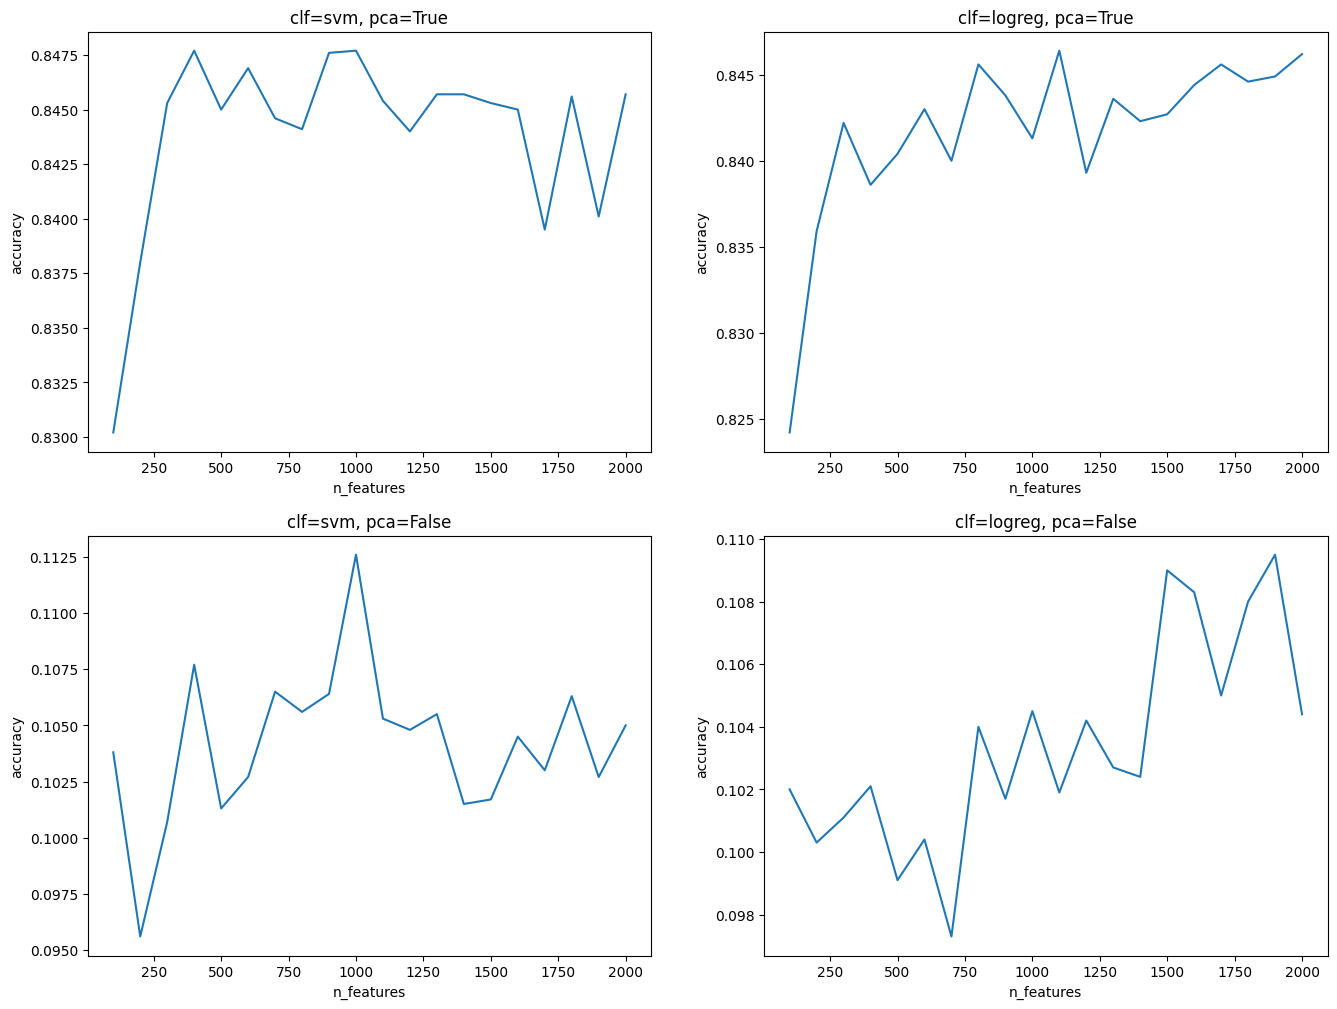

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 2, ncols =2, figsize=(16, 12))
# fig, ax = plt.subplots(2, 2)
for i, pca in enumerate([True, False]):
    for j, clf in enumerate(['svm', 'logreg']):
        ax[i, j].plot(size, accs[i][j])
        ax[i, j].set(title='clf={}, pca={}'.format(clf, pca))
        ax[i, j].set(xlabel='n_features')
        ax[i, j].set(ylabel ='accuracy')
plt.show()

Кажется нет особой разницы использовать SVM или LogReg надо только немного поподбирть параметры и можно выйти к одинаковому качеству. Зато PCA очень важно, без его использования все ломается, больше новых признаков-лучше, но от 300 выходим на плато, небольшие колебания на графиках можно объяснить случайностью признаков.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪